In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import dataset
assert tf.config.list_physical_devices('GPU')

MAXLEN = 60
BATCH_SIZE = 32

In [13]:
EMBED_DIM = 512
UNITS = 256

NIQQUD_SIZE = 16  # len(data.niqqud_table)
DAGESH_SIZE = 4   # len(data.dagesh_table)
LETTERS_SIZE = 100  # len(data.letters_table)

common_input = tf.keras.Input(batch_shape=(None, MAXLEN), batch_size=BATCH_SIZE)
common = layers.Embedding(LETTERS_SIZE, EMBED_DIM, mask_zero=True)(common_input)
common = layers.Bidirectional(layers.LSTM(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum')(common)

common = layers.add([common, layers.Bidirectional(layers.LSTM(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum')(common)])

niqqud = layers.Softmax(name='N')(layers.Dense(NIQQUD_SIZE)(common))
dagesh = layers.Softmax(name='D')(layers.Dense(DAGESH_SIZE)(common))

model = tf.keras.Model(inputs=[common_input], outputs=[niqqud, dagesh])

tf.keras.utils.plot_model(model, to_file='model.png')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

def fit(data, learning_rates):
    return model.fit(data.input_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=len(learning_rates),
          validation_data=(data.input_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: learning_rates[epoch], verbose=0),
              # tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/ckpt_{epoch}', save_weights_only=True),
          ]
    )

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 60, 512)      51200       input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 60, 256)      1574912     embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 60, 256)      1050624     bidirectional_6[0][0]            
______

In [28]:
def load_data():
    rabanit = ['birkat_hamazon.txt', 'hakdama_leorot.txt', 'hartzaat_harav.txt', 'orhot_hayim.txt', 'rambam_mamre.txt', 'short_table.txt', 'tomer_dvora.txt', 'breslev.txt']
    modern = ['atar_hashabat.txt', 'kakun.txt', 'sisters.txt', 'treasure_island.txt', 'ali_baba.txt', 'people.txt', 'ricky.txt', 'imagination.txt', 'adamtsair.txt', 'katarsis.txt']
    files = ['texts/' + f for f in modern]
    return dataset.load_file(BATCH_SIZE, 0.01, maxlen=MAXLEN, filenames=files, shuffle=True)

data = load_data()
data.print_tables()

['^', '@', '', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'D', 'O', 'R', '[', ']', '´', 'ְ', 'ַ', 'ֹ', '־', 'ׁ', 'א', 'ב', 'ג', 'ד', 'ה', 'ו', 'ז', 'ח', 'ט', 'י', 'ך', 'כ', 'ל', 'ם', 'מ', 'ן', 'נ', 'ס', 'ע', 'ף', 'פ', 'ץ', 'צ', 'ק', 'ר', 'ש', 'ת', 'ײ', '״', '–', '—', '‘', '’', '“', '”', '…', '−', '\uf04a']
['^', '@', '', 'ְ', 'ֱ', 'ֲ', 'ֳ', 'ִ', 'ֵ', 'ֶ', 'ַ', 'ָ', 'ֹ', 'ֺ', 'ֻ', 'ּ']
['^', '@', '', 'ּ']
['^', '@', '', 'ׁ', 'ׂ']


In [29]:
history = fit(data, [2e-3, 2e-4]) #, 1e-4, 3e-6])

Train on 8331 samples, validate on 85 samples
Epoch 1/2
8331/8331 [==============================] - 10s 1ms/sample - loss: 0.4377 - N_loss: 0.3647 - D_loss: 0.0724 - N_accuracy: 0.8814 - D_accuracy: 0.9739 - val_loss: 0.2293 - val_N_loss: 0.1845 - val_D_loss: 0.0480 - val_N_accuracy: 0.9409 - val_D_accuracy: 0.9828
Epoch 2/2
8331/8331 [==============================] - 10s 1ms/sample - loss: 0.2199 - N_loss: 0.1733 - D_loss: 0.0467 - N_accuracy: 0.9450 - D_accuracy: 0.9823 - val_loss: 0.1999 - val_N_loss: 0.1589 - val_D_loss: 0.0444 - val_N_accuracy: 0.9493 - val_D_accuracy: 0.9845


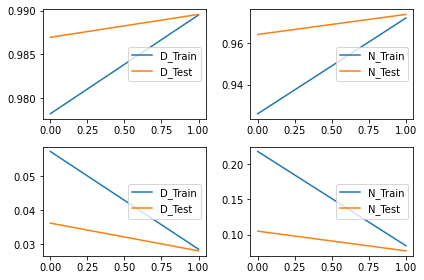

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['D', 'N'], 0):
        p = ax[n][n1]
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [32]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '.')

In [31]:
def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    prediction = model.predict(batch)
    [actual_niqqud, actual_dagesh] = [dataset.from_categorical(prediction[0]), dataset.from_categorical(prediction[1])]
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    actual = data.merge(batch, ns=actual_niqqud, ds=actual_dagesh)
    expected = data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)
    for i, (a, e) in enumerate(zip(actual, expected)):
        print('מצוי: ', a)
        print('רצוי: ', e)
        print()

print_predictions(1)

מצוי:  בָּרְסָן הַסּוּסִים וְעֵינֵיהֶם מְגַשָשוֹת בָּאֲפֵלָה אַחַר מְאֲרָבִים אֶפְשָרִיִים. אַךְ
רצוי:  בְּרֶסֶן הַסוּסִים וְעֵינֵיהֶם מְגַשְשוֹת בָּאֲפֵלָה אָחָר מָאֲרָבִים אֶפְשָרִיִים. אַךְ

מצוי:  רַק אֶת אַלְפְרֶד." "אַלְפְרֶד?" שָאֲלָה אִמָּא בְּצַחְקוֹק. "כֵּן," אָמְרָה מִיכַל,
רצוי:  רַק אֶת אַלְפְרֶד." "אַלְפְרֶד?" שָאֲלָה אִמָא בְּצִחְקוּק. "כֵּן," אָמְרָה מִיכַל,

מצוי:  אֶת אֲרוּחַת הָעֶרֶב הַטְעִימָה בְּיוֹתֵר שֶאָכְלוּ מֵימֵיהֶם. בִּשְבִיל מָה לָלֶכֶת
רצוי:  אֶת אֲרוּחַת הָעֶרֶב הַטְעִימָה בְּיוֹתֵר שֶאָכְלוּ מִימֵיהֶם. בִּשְבִיל מָה לָלֶכֶת

מצוי:  מֵעַל לְרֹאשִי. קָפַצְתִּי עַל רַגְלַי וּזְנַקְתִּי, בְּהֵטִילִי אֶת סִירַת-הַנְצָרִים אֶל
רצוי:  מֵעַל לְרֹאשִי. קָפַצְתִּי עַל רַגְלַי וְזִנַקְתִּי, בַּהֲטִילִי אֶת סִירַת-הַנְצָרִים אֶל

מצוי:  הַנְמוּכִים, לִתְפֹּס מְאָרָב וּלְהֲטוֹת אֶזֶן. יָכֹלְתִּי לְגַלוֹת בְּנְקֵל אֶת מְקוֹמָם
רצוי:  הַנְמוּכִים, לִתְפֹּס מַאֲרָב וּלְהַטוֹת אֹזֶן. יָכֹלְתִּי לְגַלוֹת בְּנָקֵל אֶת מְקוֹמָם

מצוי:  אֶתְכֶם בָּאֲזָקִים וְיַחְזִירוּ אֶתְכ